In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import re
import numpy as np
import umap.umap_ as umap
import joblib
import pickle
from sklearn.preprocessing import RobustScaler, FunctionTransformer, StandardScaler, MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
df_merged = pd.read_csv('data/processed/Ingredients_And_Nutrition_Merged_New.csv')

In [19]:
nutri_cols = ["calories", "protein", "fat", "carbohydrate"]
diet_prefs = [
    "halal", "is_lactose_free", "low_carb", "weight_loss", 
    "high_protein", "gluten_free", "dairy_free",
    "is_spicy", "is_not_fried"
]

allergen_cols = [
    "has_dairy","has_egg","has_fish","has_shellfish","has_soy","has_sesame",
    "has_wheat","has_peanut","has_treenut"
]
df_merged['text_feature'] =(
    df_merged['Title'].astype(str) + " " +
    df_merged['Ingredients_Text'].astype(str) + " "
)

In [20]:
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.decomposition import PCA

# Weighting Helper
def apply_weight(X, weight=1.0):
    return X * weight

# Pipeline
nutri_pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('weight', FunctionTransformer(apply_weight, kw_args={'weight': 3.0}))
])

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,3),
    min_df=3,
    max_df=0.8,
    stop_words='english',
    sublinear_tf=True)),
    ('svd', TruncatedSVD(n_components=50, random_state=42)),
    ('weight', FunctionTransformer(apply_weight, kw_args={'weight': 3.0}))
])

categorical_pipe_1_0 = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('weight', FunctionTransformer(apply_weight, kw_args={'weight': 0.5}))
])

# 2. Preprocessor tetap sama
preprocessor = ColumnTransformer(
    transformers=[
        ('nutri',    nutri_pipe, nutri_cols),
        ('text',     text_pipe, 'text_feature'),
        ('allergen', categorical_pipe_1_0, allergen_cols),
        ('diet',     categorical_pipe_1_0, diet_prefs)
    ],
    remainder='drop'
)

# 3. Buat Final Pipeline dengan Normalizer
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=20))
])

X_food_a = final_pipeline.fit_transform(df_merged)

In [21]:
final_pipeline

,steps,"[('preprocessor', ...), ('pca', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nutri', ...), ('text', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Training KMeans for k=2...
   Inertia: 81739.74 | Silhouette Score: 0.5124
Training KMeans for k=3...
   Inertia: 64873.40 | Silhouette Score: 0.3671
Training KMeans for k=4...
   Inertia: 52879.64 | Silhouette Score: 0.3659
Training KMeans for k=5...
   Inertia: 44885.65 | Silhouette Score: 0.3731
Training KMeans for k=6...
   Inertia: 40238.23 | Silhouette Score: 0.2827
Training KMeans for k=7...
   Inertia: 36375.03 | Silhouette Score: 0.2690
Training KMeans for k=8...
   Inertia: 33779.67 | Silhouette Score: 0.2688
Training KMeans for k=9...
   Inertia: 31237.67 | Silhouette Score: 0.2469


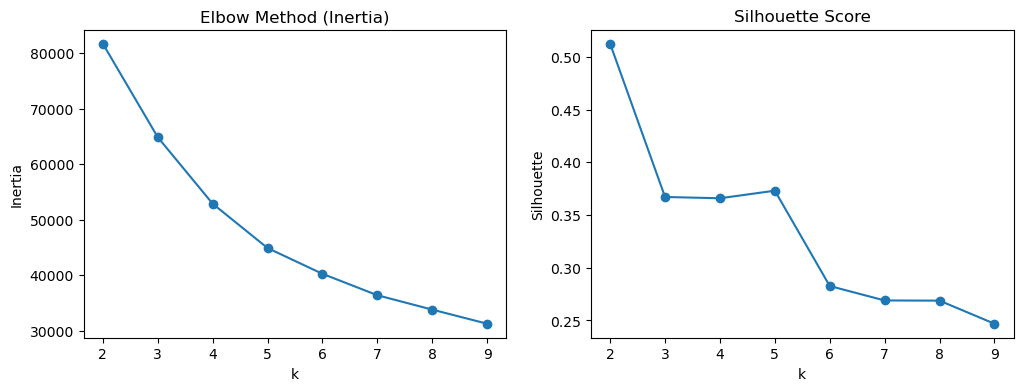

In [22]:
inertias = []
sil_scores = []
K_values = range(2, 10, 1)

for k in K_values:
    print(f"Training KMeans for k={k}...")
    # n_init='auto' atau n_init=10 untuk kestabilan
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    km.fit(X_food_a)
    
    inertias.append(km.inertia_)
    
    # Menambahkan sample_size agar tidak lemot jika data ribuan
    labels = km.labels_
    if len(X_food_a) > 10000:
        sil = silhouette_score(X_food_a, labels, sample_size=10000, random_state=42)
    else:
        sil = silhouette_score(X_food_a, labels, random_state=42)
        
    sil_scores.append(sil)
    print(f"   Inertia: {km.inertia_:.2f} | Silhouette Score: {sil:.4f}")

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(K_values, inertias, '-o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_values, sil_scores, '-o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette")

plt.show()

In [23]:
best_k = 5

kmeans = KMeans(n_clusters=best_k, random_state=42)
df_merged['cluster'] = kmeans.fit_predict(X_food_a)

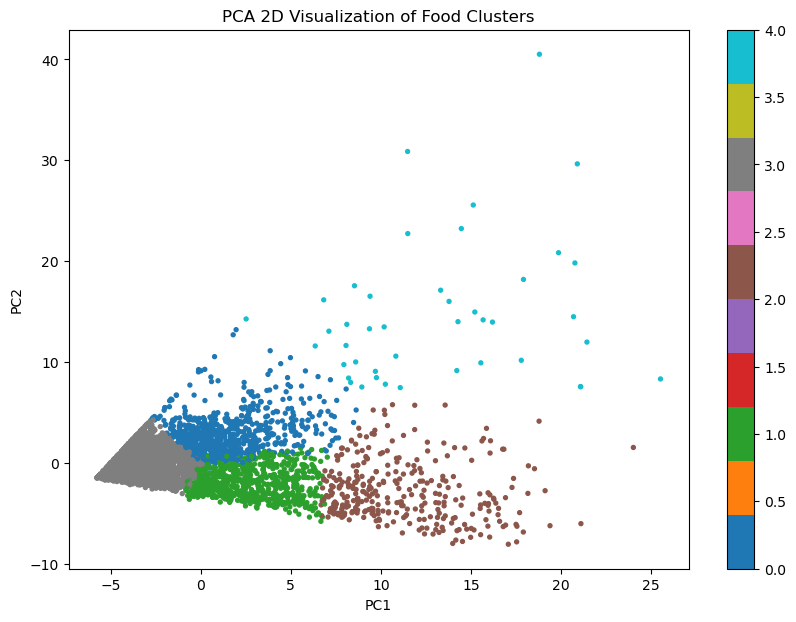

In [24]:
plt.figure(figsize=(10,7))
plt.scatter(X_food_a[:,0], X_food_a[:,1], c=df_merged["cluster"], cmap="tab10", s=8)
plt.colorbar()
plt.title("PCA 2D Visualization of Food Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [25]:
df_merged["cluster"].value_counts().sort_index()

cluster
0     738
1     740
2     327
3    2324
4      43
Name: count, dtype: int64

In [26]:
import numpy as np

def identify_cluster_characteristics(df, vectorizer, tfidf_matrix, k):
    """Show identification of cluster characteristics including sample titles, average nutrition, and dominant keywords."""
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    for c in range(k):
        print(f"\n" + "="*50)
        print(f"IDENTIFIKASI CLUSTER {c} (Total: {len(df[df.cluster == c])} Resep)")
        print("="*50)
        
        # 1. Tampilkan Sampel Judul
        print("\n[ Sampel Resep ]")
        sample_titles = df[df.cluster == c]["Title"].head(10).tolist()
        for title in sample_titles:
            print(f"- {title}")
            
        # 2. Tampilkan Rata-rata Nutrisi
        print("\n[ Profil Nutrisi Rata-rata ]")
        # Misal kolom: 'calories', 'protein', 'fat'
        avg_nutri = df[df.cluster == c][nutri_cols].mean()
        print(avg_nutri.to_string())

        # 3. Tampilkan Kata Kunci Terkuat (TF-IDF)
        cluster_indices = np.where(df.cluster == c)[0]
        if len(cluster_indices) > 0:
            cluster_tfidf_mean = np.asarray(tfidf_matrix[cluster_indices].mean(axis=0)).ravel()
            top_keywords_idx = cluster_tfidf_mean.argsort()[-10:][::-1]
            print("\n[ Kata Kunci Dominan (Bahan) ]")
            print(", ".join(feature_names[top_keywords_idx]))
            
identify_cluster_characteristics(df_merged, 
                                 final_pipeline.named_steps['preprocessor'].named_transformers_['text']['tfidf'],
                                 final_pipeline.named_steps['preprocessor'].named_transformers_['text']['tfidf'].transform(df_merged['text_feature']), 
                                 best_k)


IDENTIFIKASI CLUSTER 0 (Total: 738 Resep)

[ Sampel Resep ]
- Peach Cobbler
- Blueberry Lemon Corn Muffins
- Banana Cream Pie
- Chilaquiles
- Triple-Cherries Jubilee
- Hot Chocolate Baked French Toast
- Pear Crisps with Vanilla Brown Butter
- Pumpkin Spice Cupcakes
- Pasta Salad with Tomatoes and Corn
- Fettuccine with Shredded Zucchini, Fresh Ricotta, and Lemon Zest

[ Profil Nutrisi Rata-rata ]
calories        624.906504
protein          15.487805
fat              29.532520
carbohydrate     74.290650

[ Kata Kunci Dominan (Bahan) ]
sugar, cream, butter, unsalted, unsalted butter, salt, vanilla, flour, grated, oil

IDENTIFIKASI CLUSTER 1 (Total: 740 Resep)

[ Sampel Resep ]
- Shrimp Creole
- Chicken Piccata
- Liu Shaokun's Spicy Buckwheat Noodles with Chicken
- Dill-Crusted Pork Tenderloin with Farro, Pea, and Blistered Tomato Salad
- Grilled Marinated Leg of Lamb
- Rack of Lamb with Garlic and Herbs
- Pickled Shrimp
- Chile-Marinated Pork with Vietnamese Brussels Sprouts
- Steak Piz

In [27]:
for c in range(best_k):
    print(f"\n===== Cluster {c} =====")
    print(df_merged[df_merged.cluster == c]["Title"].head(30).tolist())



===== Cluster 0 =====
['Peach Cobbler', 'Blueberry Lemon Corn Muffins', 'Banana Cream Pie', 'Chilaquiles', 'Triple-Cherries Jubilee', 'Hot Chocolate Baked French Toast', 'Pear Crisps with Vanilla Brown Butter', 'Pumpkin Spice Cupcakes', 'Pasta Salad with Tomatoes and Corn', 'Fettuccine with Shredded Zucchini, Fresh Ricotta, and Lemon Zest', 'Strawberry Shortcake with Thyme and Whipped Cream', 'Crispy Cornmeal-Bacon Waffles', 'Grape and Rosemary Flatbread', 'Roasted Quinoa and Tomato Soup With Parmesan Wafers and Crispy Basil', 'Vegetarian Brown Rice Salad With Parsnips and Whipped Ricotta', 'Apple Pandowdy', 'Skillet Phyllo Pie with Butternut Squash, Kale, and Goat Cheese', 'Green Curry with Brown Rice Noodles and Swiss Chard', 'Stuffing Fried Rice', '3-Ingredient Sweet Potato Casserole with Maple Pecans', 'Chocolate-Pecan Sheet Pie with Molasses', 'Kale, Tomato, and Lemon Magic One-Pot Spaghetti', 'Almond and Jam Tart', 'Slow-Cooker Macaroni and Cheese', 'Butternut Squash Vegducken w

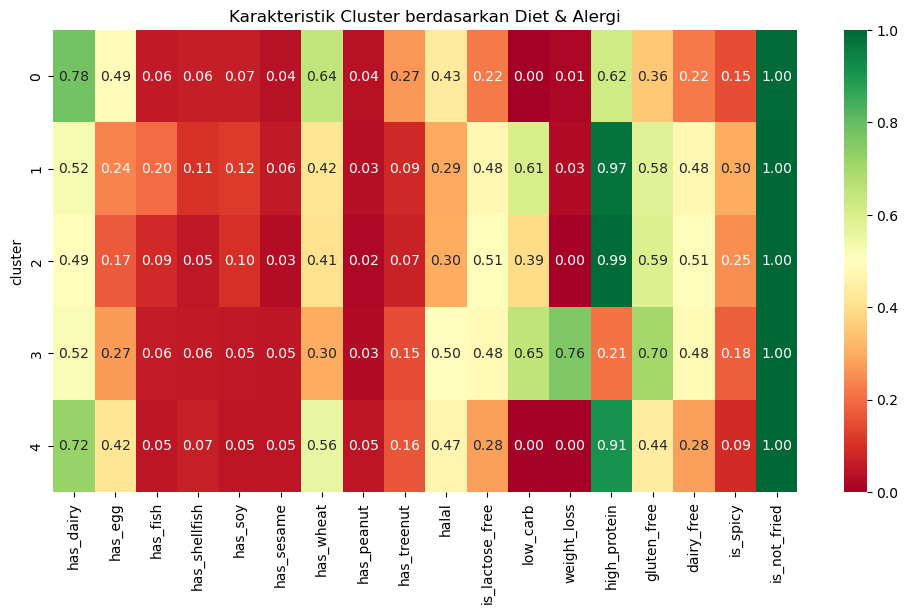

In [28]:
# Ambil fitur diet & allergen
diet_summary = df_merged.groupby('cluster')[allergen_cols + diet_prefs].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(diet_summary, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title("Karakteristik Cluster berdasarkan Diet & Alergi")
plt.show()

In [29]:
# Silhoutte score global
sil_score = silhouette_score(X_food_a, df_merged["cluster"])
print(f"Silhouette Score: {sil_score}")

# Davies–Bouldin Index (DBI)
dbi = davies_bouldin_score(X_food_a, df_merged["cluster"])
print(f"Davies–Bouldin Index: {dbi}")

# Calinski–Harabasz Index (CH Score)
ch = calinski_harabasz_score(X_food_a, df_merged['cluster'])
print(f"Calinski–Harabasz Index: {ch}")

Silhouette Score: 0.37339797768102834
Davies–Bouldin Index: 1.0555620244929138
Calinski–Harabasz Index: 2273.9635363334246


In [30]:
# Silhoutte score per cluster
sample_scores = silhouette_samples(X_food_a, df_merged["cluster"])
df_merged["sil_score"] = sample_scores

df_merged.groupby("cluster")["sil_score"].mean()

cluster
0    0.220955
1    0.230539
2    0.228920
3    0.489826
4    0.254447
Name: sil_score, dtype: float64

In [ ]:
metadata = df_merged[['recipe_id', 'Title', 'cluster', 'text_feature', 'cooking_time'] + nutri_cols + allergen_cols + diet_prefs ].copy()

data_to_save = {
    'metadata' : metadata,
    'matrix' : X_food_a,
    'pipeline' : final_pipeline,
}
with open('models/recipe_engine_kmeans.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"File pkl berhasil dibuat!")

File pkl berhasil dibuat!
